# Discovering hidden factors of variation in deep networks 

Example of the autoencoder archtecture from [Cheung et al.,(2014)](https://arxiv.org/abs/1412.6583) in Tensorflow 1.6.


Based on https://github.com/Lasagne/Lasagne/blob/highway_example/examples/Hidden%20factors.ipynb


In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

from tensorflow.contrib.layers import xavier_initializer


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Loading data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## Creating models variables

In [4]:
input_dim = 784 # MNIST data input (img shape: 28*28)
output_dim = 10 # MNIST total classes (0-9 digits)
latent_dim = 2
num_hidden_units=500


# variables
X = tf.placeholder(tf.float32, shape=[None, input_dim])
y_ = tf.placeholder(tf.float32, shape=[None, output_dim])

# encoder
with tf.variable_scope("encoder"):
    enc_W1 = tf.get_variable("W1", shape=[input_dim, num_hidden_units], initializer=xavier_initializer())
    enc_b1 = tf.get_variable("b1", shape=[num_hidden_units], initializer=tf.zeros_initializer())

    enc_W2 = tf.get_variable("W2", shape=[num_hidden_units, num_hidden_units], initializer=xavier_initializer())
    enc_b2 = tf.get_variable("b2", shape=[num_hidden_units], initializer=tf.zeros_initializer())

# learned representation
with tf.variable_scope("representation"):
    obs_W = tf.get_variable("W_obs", shape=[num_hidden_units, output_dim], initializer=xavier_initializer())
    obs_b = tf.get_variable("b_obs", shape=[output_dim], initializer=tf.zeros_initializer())

    lat_W = tf.get_variable("W_lat", shape=[num_hidden_units, latent_dim], initializer=xavier_initializer())
    lat_b = tf.get_variable("b_lat", shape=[latent_dim], initializer=tf.zeros_initializer())

# decoder
with tf.variable_scope("decoder"):
    dec_W1 = tf.get_variable("W1", shape=[latent_dim+output_dim, num_hidden_units], initializer=xavier_initializer())
    dec_b1 = tf.get_variable("b1", shape=[num_hidden_units], initializer=tf.zeros_initializer())

    dec_W2 = tf.get_variable("W2", shape=[num_hidden_units, num_hidden_units], initializer=xavier_initializer())
    dec_b2 = tf.get_variable("b2", shape=[num_hidden_units], initializer=tf.zeros_initializer())

# output
with tf.variable_scope("output"):
    out_W = tf.get_variable("W", shape=[num_hidden_units, input_dim], initializer=xavier_initializer())
    out_b = tf.get_variable("b", shape=[input_dim], initializer=tf.zeros_initializer())




## Creating training model function

In [7]:
# training model
# encoder
noise_factor = 0.05
l_encoder1 = tf.nn.relu(tf.matmul((X + tf.random_normal(shape=tf.shape(X), mean=0., stddev=noise_factor)),
                            enc_W1) + enc_b1) # layer with noise
l_encoder2 = tf.nn.relu(tf.matmul(l_encoder1, enc_W2) + enc_b2)

# learned representation
l_observed = tf.nn.softmax(tf.matmul(l_encoder2, obs_W) + obs_b)
l_latent = tf.matmul(l_encoder2, lat_W) + lat_b # linear

l_representation = tf.concat([l_latent, y_], 1)

# decoder
l_decoder1 = tf.nn.relu(tf.matmul(l_representation, dec_W1) + dec_b1)
l_decoder2 = tf.nn.relu(tf.matmul(l_decoder1, dec_W2) + dec_b2)

# reconstruction layer
l_decoder_out = tf.matmul(l_decoder2, out_W) + out_b

## Cost function

In [19]:
# cost
alpha=1.0
beta=10.0
gamma=10.0

# unsupervised cost: mean squared error
U = tf.reduce_mean(tf.square(l_decoder_out - X))

# supervised cost: categorical cross-entropy
S = tf.reduce_mean(-tf.reduce_sum(y_*tf.log(tf.clip_by_value(l_observed,1e-10,1.0)), reduction_indices=[1]))

# XCov cost: cross-covariance
y_pred_mean = tf.reduce_mean(l_observed, axis=0)
z_mean = tf.reduce_mean(l_latent, axis=0)
y_pred_centered = l_observed - y_pred_mean # (n, i)
z_centered = l_latent - z_mean # (n, j)

outer_prod =  tf.matmul(tf.expand_dims(y_pred_centered, 2), tf.expand_dims(z_centered, 1))  # (n, i, j)
C = 0.5 * tf.reduce_sum(tf.square(tf.reduce_mean(outer_prod, axis=0)))

cost = alpha * U + beta * S + gamma * C
# reg = tf.nn.l2_loss(enc_W1) \
#      + tf.nn.l2_loss(enc_W2) \
#      + tf.nn.l2_loss(obs_W) \
#      + tf.nn.l2_loss(lat_W) \
#      + tf.nn.l2_loss(dec_W1) \
#      + tf.nn.l2_loss(dec_W2) \
#      + tf.nn.l2_loss(out_W)

# l2_reg = 0.01
# cost += l2_reg * reg

## Training loop

In [20]:
# training
learning_rate = 1
optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(cost)

display_step = 10
training_epochs = 201
batch_size = 100

with tf.name_scope("streaming"):
    accuracy, acc_update_op = tf.metrics.accuracy(tf.argmax(y_, 1), tf.argmax(l_observed, 1))

# Initializing the variables
init_global = tf.global_variables_initializer()
init_local = tf.local_variables_initializer()

sess = tf.Session()
sess.run(init_global)
sess.run(init_local)

for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, _, c = sess.run([train_op, acc_update_op, cost], feed_dict={X: batch_x, y_: batch_y})
        
        # Compute average loss
        avg_cost += c / total_batch
    
    # Compute training accuracy
    acc = sess.run(accuracy)
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost), "acc={:.9f}".format(acc))
print("Optimization Finished!")


Epoch: 0001 cost=2.959245106 acc=0.916054547
Epoch: 0011 cost=0.169403028 acc=0.980570257
Epoch: 0021 cost=0.067335138 acc=0.989347160
Epoch: 0031 cost=0.051186418 acc=0.992750168
Epoch: 0041 cost=0.046252413 acc=0.994515717
Epoch: 0051 cost=0.044156006 acc=0.995591104
Epoch: 0061 cost=0.042490995 acc=0.996313870
Epoch: 0071 cost=0.041177537 acc=0.996833026
Epoch: 0081 cost=0.040424072 acc=0.997224033
Epoch: 0091 cost=0.039621783 acc=0.997529089
Epoch: 0101 cost=0.039128850 acc=0.997773707
Epoch: 0111 cost=0.038588014 acc=0.997974277
Epoch: 0121 cost=0.038157675 acc=0.998141706
Epoch: 0131 cost=0.037721965 acc=0.998283565
Epoch: 0141 cost=0.037358414 acc=0.998405278
Epoch: 0151 cost=0.037082090 acc=0.998510897
Epoch: 0161 cost=0.036742769 acc=0.998603404
Epoch: 0171 cost=0.036525176 acc=0.998685062
Epoch: 0181 cost=0.036260757 acc=0.998757720
Epoch: 0191 cost=0.036099137 acc=0.998822749
Epoch: 0201 cost=0.035845751 acc=0.998881340
Optimization Finished!


## Creating testing functions

The noise at the input layer is removed.

In [21]:
# testing model
# encoder
l_encoder1_test = tf.nn.relu(tf.matmul(X, enc_W1) + enc_b1)
l_encoder2_test = tf.nn.relu(tf.matmul(l_encoder1_test, enc_W2) + enc_b2)

# learned representation
l_observed_test = tf.nn.softmax(tf.matmul(l_encoder2_test, obs_W) + obs_b)
l_latent_test = tf.matmul(l_encoder2_test, lat_W) + lat_b # linear


given_z = tf.placeholder(tf.float32, shape=[None, 2])
given_y = tf.placeholder(tf.float32, shape=[None, output_dim])


l_representation_test = tf.concat([given_z, given_y], 1)

# decoder
l_decoder1_test = tf.nn.relu(tf.matmul(l_representation_test, dec_W1) + dec_b1)
l_decoder2_test = tf.nn.relu(tf.matmul(l_decoder1_test, dec_W2) + dec_b2)

# reconstruction layer
l_decoder_out_test = tf.matmul(l_decoder2_test, out_W) + out_b


## Visualizating latent space

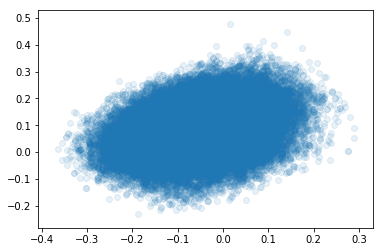

In [22]:
z_vals = np.empty((0,2), float)
# Loop over all batches
for i in range(total_batch):
    batch_x, batch_y = mnist.train.next_batch(batch_size)    
    batch_z = sess.run(l_latent_test, feed_dict={X: batch_x}) # TODO usar testing model
    z_vals = np.append(z_vals, batch_z, axis=0)

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(z_vals[:, 0], z_vals[:, 1], alpha=0.1)
plt.show()


## Sampling latent space

In [23]:
ys = np.repeat(np.arange(10), 9).astype('int32')
ys = sess.run(tf.one_hot(ys, output_dim))
zs = np.tile(np.linspace(-0.5, 0.5, 9), 10).astype("float32")
z1s = np.vstack([zs, np.zeros_like(zs)]).T
z2s = np.vstack([np.zeros_like(zs), zs]).T

In [24]:
reconstructions_z1 = sess.run(l_decoder_out_test, feed_dict={given_z:z1s, given_y:ys})
reconstructions_z2 = sess.run(l_decoder_out_test, feed_dict={given_z:z2s, given_y:ys})

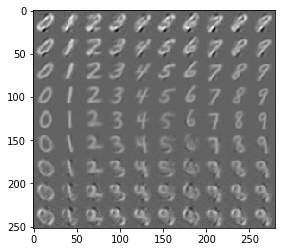

In [25]:
im1 = reconstructions_z1.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im1, cmap=plt.cm.gray)
plt.show()

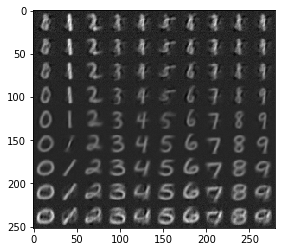

In [26]:
im2 = reconstructions_z2.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im2, cmap=plt.cm.gray)
plt.show()